In [1]:
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from tqdm.auto import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
all_start = time.time()

# Parameters

In [3]:
M_t = 40
N_t = 20

M_a = 20
N_a = 3

x_o_t = 10
y_o_t = 5
I_0_t = 2.5
sigma_I_t = 0.3

x_o_a = 100
y_o_a = 15
I_0_a = 3.6
sigma_I_a = 0.3

phi_0_t = 1
sigma_phi_t = 1

phi_0_a = 1
sigma_phi_a = 10

L_ex_t = 0.15
L_in_t = 0.05
sigma_ex_t = 1
sigma_in_t = 1

L_ex_a = 0.15
L_in_a = 0.05
sigma_ex_a = 20
sigma_in_a = 80

W0_t = 6.5
B0_t = 2.5

W0_a = 6.5
B0_a = 2.5

k1 = 15
k2 = 800
alpha = 0.9
Lim = 65

fmin_t = -0.12
fmax_t = 1
qc_t = 19.43
r_t = 0.34

fmin_a = -0.12
fmax_a = 1
qc_a = 19.43
r_a = 0.34

fmin_m = 0
fmax_m = 1
qc_m = 12
r_m = 0.6

tau = 20

d_t = 0.4
total_time = 200

In [4]:
# M_t = 40
# N_t = 20

# M_a = 20
# N_a = 3

# I_0_t = 2.5
# sigma_I_t = 0.3

# I_0_a = 3.6
# sigma_I_a = 0.3

# x_o_t = 10
# y_o_t = 5

# x_o_a = 100
# y_o_a = 5

# phi_0_t = 1
# sigma_phi_t = 0.5

# phi_0_a = 1
# sigma_phi_a = 10

# L_ex_t = 0.15
# sigma_ex_t = 1
# L_in_t = 0.05
# sigma_in_t = 4

# L_ex_a = 0.15
# sigma_ex_a = 20
# L_in_a = 0.05
# sigma_in_a = 80

# W0_t = 6.5
# B0_t = 2.5

# W0_a = 6.5
# B0_a = 2.5

# k1 = 10
# k2 = 700
# alpha = 0.9
# Lim = 60

# fmin_t = -0.12
# fmax_t = 1
# qc_t = 19.43
# r_t = 0.34

# fmin_a = -0.12
# fmax_a = 1
# qc_a = 19.43
# r_a = 0.34

# fmin_m = 0
# fmax_m = 1
# qc_m = 12
# r_m = 0.6

# tau = 20

# d_t = 0.4
# total_time = 200

In [5]:
delta_val = 0.2

In [6]:
def x_t(i):
    # i start with 1
    return i * 0.5

def y_t(j):
    # j start with 1
    return j * 0.5

def x_a(i):
    # i start with 1
    return i * 10 - 5

def y_a(j):
    # j start with 1
    return j * 10 - 15

In [7]:
def I_s(x, y, x_o, y_o, I_0, sigma_I):
    return I_0 * np.exp( - ((x - x_o)**2 + (y - y_o)**2) / (2 * (sigma_I**2)))

def I_t(x, y):
    return I_s(x, y, x_o_t, y_o_t, I_0_t, sigma_I_t)

def I_a(x, y):
    return I_s(x, y, x_o_a, y_o_a, I_0_a, sigma_I_a)

In [8]:
width_t = np.arange(0, 10 + delta_val, delta_val)
length_t = np.arange(0, 20 + delta_val, delta_val)

I_t_net = torch.zeros(len(width_t), len(length_t))

for x in range(len(length_t)):
    for y in range(len(width_t)):
        x_l = x * delta_val
        y_n = y * delta_val
        I_t_net[y][x] = I_t(x_l, y_n)

[Text(0, 0, '0'), Text(50, 0, '10'), Text(100, 0, '20')]

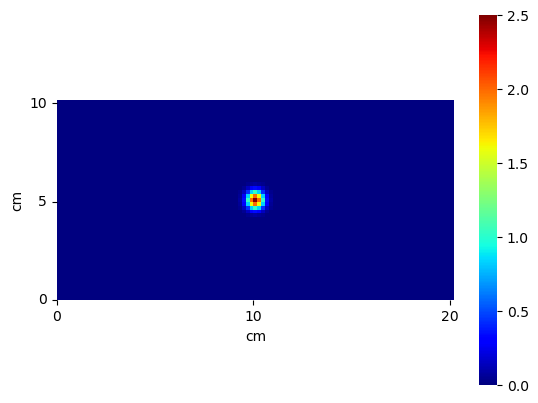

In [9]:
ax = sns.heatmap(I_t_net.cpu().detach().numpy(), square=True, cmap="jet")

y_num_ticks = 3
yticks = np.linspace(0, len(width_t) - 1, y_num_ticks, dtype=np.int32)
yticklabels = [int(width_t[idx]) for idx in yticks]

ax.invert_yaxis()
ax.set_ylabel('cm')
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)

x_num_ticks = 3
xticks = np.linspace(0, len(length_t) - 1, x_num_ticks, dtype=np.int32)
xticklabels = [int(length_t[idx]) for idx in xticks]

ax.set_xlabel('cm')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation='horizontal')

In [10]:
width_a = np.arange(0, 30 + delta_val, delta_val)
length_a = np.arange(0, 200 + delta_val, delta_val)

I_a_net = torch.zeros(len(width_a), len(length_a))

for x in range(len(length_a)):
    for y in range(len(width_a)):
        x_l = x * delta_val
        y_n = y * delta_val
        I_a_net[y][x] = I_a(x_l, y_n)

[Text(0, 0, '0'),
 Text(100, 0, '20'),
 Text(200, 0, '40'),
 Text(300, 0, '60'),
 Text(400, 0, '80'),
 Text(500, 0, '100'),
 Text(600, 0, '120'),
 Text(700, 0, '140'),
 Text(800, 0, '160'),
 Text(900, 0, '180'),
 Text(1000, 0, '200')]

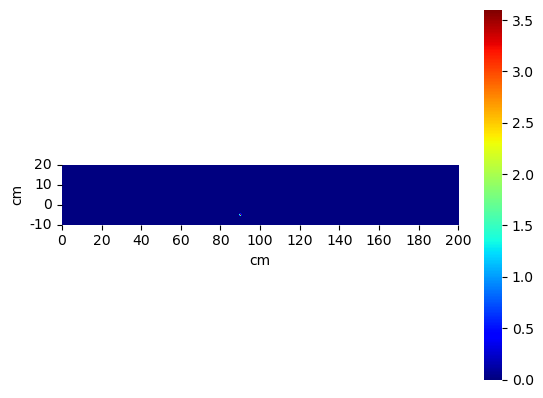

In [11]:
ax = sns.heatmap(I_a_net.cpu().detach().numpy(), square=True, cmap="jet")

y_num_ticks = 4
yticks = [0, 50, 100, 150]
yticklabels = [int(width_a[idx]) - 10 for idx in yticks]

ax.invert_yaxis()
ax.set_ylabel('cm')
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)

x_num_ticks = 11
xticks = np.linspace(0, len(length_a) - 1, x_num_ticks, dtype=np.int32)
xticklabels = [int(length_a[idx]) for idx in xticks]

ax.set_xlabel('cm')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation='horizontal')

In [12]:
def phi_s(x, y, x_i, y_j, phi_0, sigma_phi):
    return phi_0 * np.exp( - ((x - x_i)**2 + (y - y_j)**2) / (2 * (sigma_phi**2)))

def phi_t(x, y, x_i, y_j):
    return phi_s(x, y, x_i, y_j, phi_0_t, sigma_phi_t)

def phi_a(x, y, x_i, y_j):
    return phi_s(x, y, x_i, y_j, phi_0_a, sigma_phi_a)

In [13]:
def phi1_t(d=0.5, delta_x_l=0.2, delta_y_n=0.2):
    area_t = torch.zeros(N_t, M_t, device=device)
    
    for i in range(M_t):
        for j in range(N_t):
            sum_phi_t = 0.0
            
            for x_l in np.arange(0, 20 + delta_x_l, delta_x_l):
                for y_n in np.arange(0, 10+ delta_y_n, delta_y_n):
                    x_i = x_t(i + 1)
                    y_j = y_t(j + 1)
                    
                    sum_phi_t += I_t(x_l, y_n) * phi_t(x_l, y_n, x_i, y_j) * delta_x_l * delta_y_n
            
            area_t[j][i] = sum_phi_t
                    
    return area_t

[Text(0, 0, '0'), Text(20, 0, '20'), Text(40, 0, '40')]

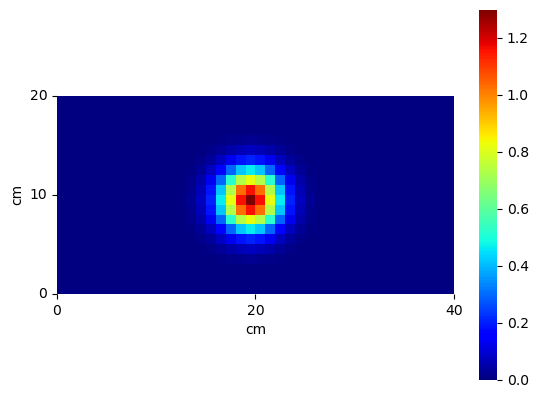

In [14]:
ax = sns.heatmap(phi1_t().cpu().detach().numpy(), square=True, cmap="jet")

y_num_ticks = 3
yticks = np.linspace(0, N_t, y_num_ticks, dtype=np.int32)
yticklabels = [int(range(N_t + 1)[idx]) for idx in yticks]

ax.invert_yaxis()
ax.set_ylabel('cm')
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)

x_num_ticks = 3
xticks = np.linspace(0, M_t, x_num_ticks, dtype=np.int32)
xticklabels = [int(range(M_t + 1)[idx]) for idx in xticks]

ax.set_xlabel('cm')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation='horizontal')

In [15]:
def phi1_a(d=10, delta_x_l=0.2, delta_y_n=0.2):
    area_a = torch.zeros(N_a, M_a, device=device)
    
    for i in range(M_a):
        for j in range(N_a):
            sum_phi_a = 0.0
            
            for x_l in np.arange(0, 200 + delta_x_l, delta_x_l):
                for y_n in np.arange(0, 30 + delta_y_n, delta_y_n):
                    x_i = x_a(i + 1)
                    y_j = y_a(j + 1)
                    
                    sum_phi_a += I_a(x_l, y_n) * phi_a(x_l, y_n, x_i, y_j) * delta_x_l * delta_y_n
#                     sum_phi_a += I_a(x_l, y_n) * phi_a(x_l, y_n, x_i, y_j)
            
            area_a[j][i] = sum_phi_a
            
    return area_a

[Text(0, 0, '0'),
 Text(2, 0, '20'),
 Text(4, 0, '40'),
 Text(6, 0, '60'),
 Text(8, 0, '80'),
 Text(10, 0, '100'),
 Text(12, 0, '120'),
 Text(14, 0, '140'),
 Text(16, 0, '160'),
 Text(18, 0, '180'),
 Text(20, 0, '200')]

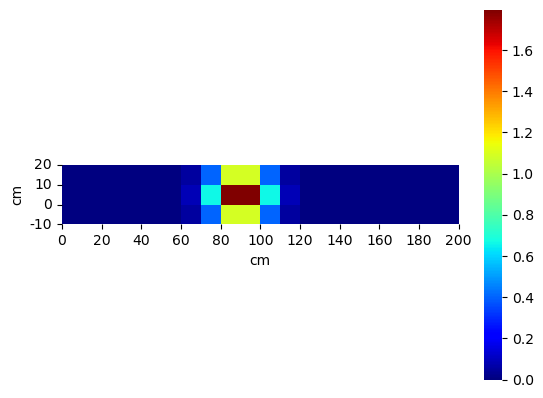

In [16]:
ax = sns.heatmap(phi1_a().cpu().detach().numpy(), square=True, cmap="jet")

y_num_ticks = 4
yticks = np.linspace(0, N_a, y_num_ticks, dtype=np.int32)
yticklabels = [int(range(N_a + 1)[idx]) * 10 - 10 for idx in yticks]

ax.invert_yaxis()
ax.set_ylabel('cm')
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels, rotation='horizontal')

x_num_ticks = 11
xticks = np.linspace(0, M_a, x_num_ticks, dtype=np.int32)
xticklabels = [int(range(M_a + 1)[idx]) * 10 for idx in xticks]

ax.set_xlabel('cm')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation='horizontal')

In [17]:
def L_s(D_x, D_y, L_ex, sigma_ex, L_in, sigma_in):
    ve = L_ex * np.exp( - (D_x**2 + D_y**2) / (2 * (sigma_ex**2)))
    vi = L_in * np.exp( - (D_x**2 + D_y**2) / (2 * (sigma_in**2)))
    
    return ve - vi

def L_t(D_x, D_y):
    # i, j, h, k start with 0
    
    return L_s(D_x, D_y, L_ex_t, sigma_ex_t, L_in_t, sigma_in_t)

def L_a(D_x, D_y):
    # i, j, h, k start with 0

    return L_s(D_x, D_y, L_ex_a, sigma_ex_a, L_in_a, sigma_in_a)

In [18]:
def L2_t(i, j):
    # i, j start with 1; h, k start with 0
    conn_t = torch.zeros(N_t, M_t, device=device)
    
    for h in range(M_t):
        for k in range(N_t):
            if h + 1 == i and k + 1 == j:
                conn_t[k][h] = 0
            else:
                D_x = x_t(h + 1) - x_t(i)
                D_y = y_t(k + 1) - y_t(j)
                conn_t[k][h] = L_t(D_x, D_y)
    
    return conn_t

def L2_a(i, j):
    # i, j start with 1; h, k start with 0
    conn_a = torch.zeros(N_a, M_a, device=device)
    
    for h in range(M_a):
        for k in range(N_a):
            if h + 1 == i and k + 1 == j:
                conn_a[k][h] = 0
            else:
                D_x = x_a(h + 1) - x_a(i)
                D_y = y_a(k + 1) - y_a(j)
                conn_a[k][h] = L_a(D_x, D_y)
    
    return conn_a

In [19]:
s = time.time()

L_net_t = {}

for i in range(M_t):
    for j in (range(N_t)):
        L_net_t[(i + 1, j + 1)] = L2_t(i + 1, j + 1)

time.time() - s

48.74979496002197

[Text(0, 0, '0'), Text(20, 0, '20'), Text(40, 0, '40')]

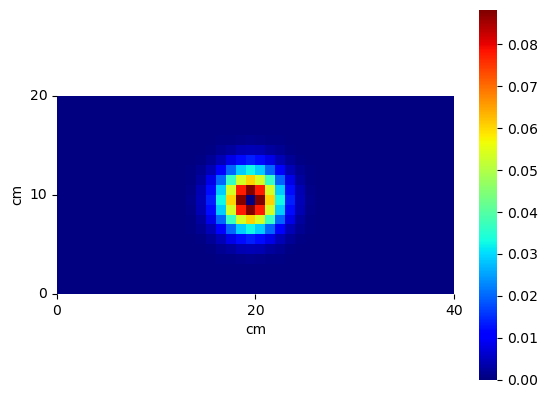

In [20]:
ax = sns.heatmap(L_net_t[(20, 10)].cpu().detach().numpy(), square=True, cmap="jet")

y_num_ticks = 3
yticks = np.linspace(0, N_t, y_num_ticks, dtype=np.int32)
yticklabels = [int(range(N_t + 1)[idx]) for idx in yticks]

ax.invert_yaxis()
ax.set_ylabel('cm')
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)

x_num_ticks = 3
xticks = np.linspace(0, M_t, x_num_ticks, dtype=np.int32)
xticklabels = [int(range(M_t + 1)[idx]) for idx in xticks]

ax.set_xlabel('cm')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation='horizontal')

In [21]:
s = time.time()

L_net_a = {}

for i in range(M_a):
    for j in (range(N_a)):
        L_net_a[(i + 1, j + 1)] = L2_a(i + 1, j + 1)

time.time() - s

0.2962660789489746

[Text(0, 0, '0'),
 Text(2, 0, '20'),
 Text(4, 0, '40'),
 Text(6, 0, '60'),
 Text(8, 0, '80'),
 Text(10, 0, '100'),
 Text(12, 0, '120'),
 Text(14, 0, '140'),
 Text(16, 0, '160'),
 Text(18, 0, '180'),
 Text(20, 0, '200')]

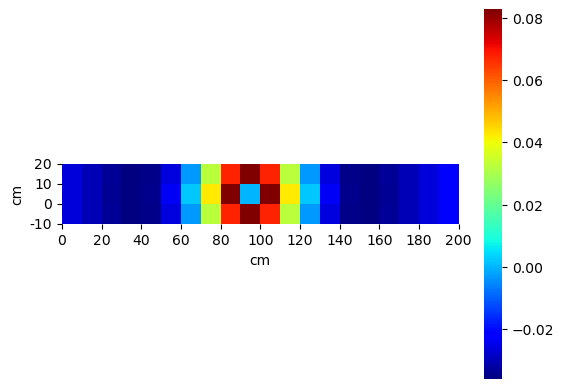

In [22]:
ax = sns.heatmap(L_net_a[(10, 2)].cpu().detach().numpy(), square=True, cmap="jet")

y_num_ticks = 4
yticks = np.linspace(0, N_a, y_num_ticks, dtype=np.int32)
yticklabels = [int(range(N_a + 1)[idx]) * 10 - 10 for idx in yticks]

ax.invert_yaxis()
ax.set_ylabel('cm')
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels, rotation='horizontal')

x_num_ticks = 11
xticks = np.linspace(0, M_a, x_num_ticks, dtype=np.int32)
xticklabels = [int(range(M_a + 1)[idx]) * 10 for idx in xticks]

ax.set_xlabel('cm')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation='horizontal')

In [23]:
def W_t():
    return W0_t

def B_t():
    return B0_t

def Forward_t(M=40, N=20):
    return torch.full((N, M), W0_t, device=device)

def Backward_t(M=40, N=20):
    return torch.full((N, M), B0_t, device=device)

In [24]:
s = time.time()

W_t_net = Forward_t()
B_t_net = Backward_t()

time.time() - s

0.0

<AxesSubplot: >

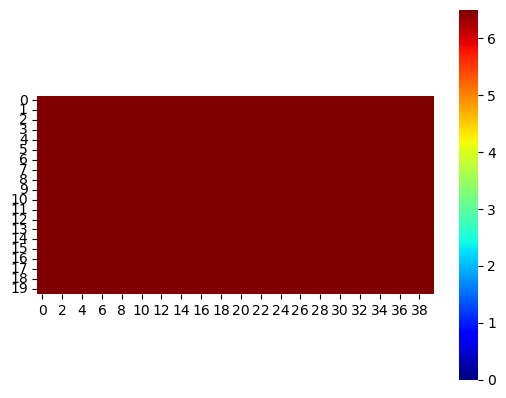

In [25]:
sns.heatmap(W_t_net.cpu().detach().numpy(), vmin=0, square=True, cmap="jet")

<AxesSubplot: >

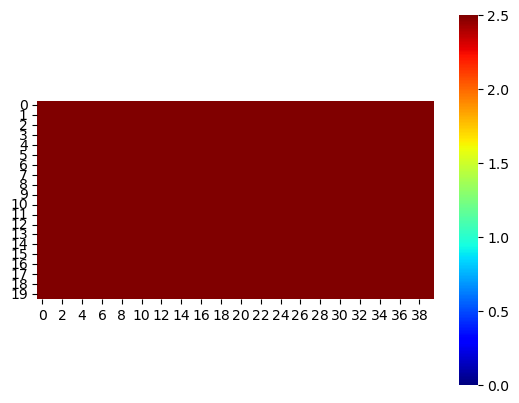

In [26]:
sns.heatmap(B_t_net.cpu().detach().numpy(), vmin=0, square=True, cmap="jet")

In [27]:
def W_a(D):
    return alpha * W0_a * np.exp(-( D / k1 )) + (1 - alpha) * W0_a * np.exp(-( D / k2 ))

def B_a(D):
    return alpha * B0_a * np.exp(-( D / k1 )) + (1 - alpha) * B0_a * np.exp(-( D / k2 ))

def D_a(i, j):
    if x_a(i) < Lim:
        return 0
    else:
        return x_a(i) - Lim
    
def Forward_a(M=20, N=3):
    conn_matrix = torch.zeros(N, M, device=device)
    
    for i in range(M):
        for j in range(N):
            conn_matrix[j][i] = W_a(D_a(i, j))
    
    return conn_matrix

def Backward_a(M=20, N=3):
    conn_matrix = torch.zeros(N, M, device=device)
    
    for i in range(M):
        for j in range(N):
            conn_matrix[j][i] = B_a(D_a(i, j))
    
    return conn_matrix

In [28]:
s = time.time()

W_a_net = Forward_a()
B_a_net = Backward_a()

time.time() - s

0.012009382247924805

[Text(0, 0, '0'),
 Text(2, 0, '20'),
 Text(4, 0, '40'),
 Text(6, 0, '60'),
 Text(8, 0, '80'),
 Text(10, 0, '100'),
 Text(12, 0, '120'),
 Text(14, 0, '140'),
 Text(16, 0, '160'),
 Text(18, 0, '180'),
 Text(20, 0, '200')]

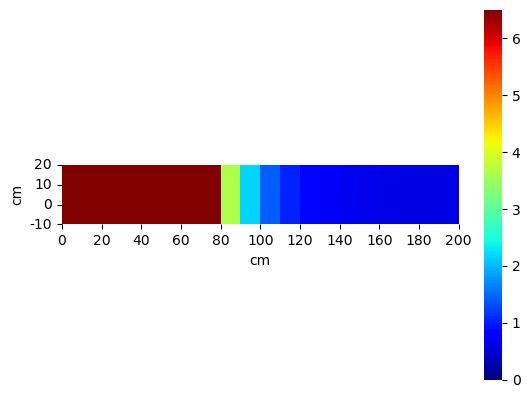

In [29]:
ax = sns.heatmap(W_a_net.cpu().detach().numpy(), vmin=0, square=True, cmap="jet")

y_num_ticks = 4
yticks = np.linspace(0, N_a, y_num_ticks, dtype=np.int32)
yticklabels = [int(range(N_a + 1)[idx]) * 10 - 10 for idx in yticks]

ax.invert_yaxis()
ax.set_ylabel('cm')
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels, rotation='horizontal')

x_num_ticks = 11
xticks = np.linspace(0, M_a, x_num_ticks, dtype=np.int32)
xticklabels = [int(range(M_a + 1)[idx]) * 10 for idx in xticks]

ax.set_xlabel('cm')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation='horizontal')

[Text(0, 0, '0'),
 Text(2, 0, '20'),
 Text(4, 0, '40'),
 Text(6, 0, '60'),
 Text(8, 0, '80'),
 Text(10, 0, '100'),
 Text(12, 0, '120'),
 Text(14, 0, '140'),
 Text(16, 0, '160'),
 Text(18, 0, '180'),
 Text(20, 0, '200')]

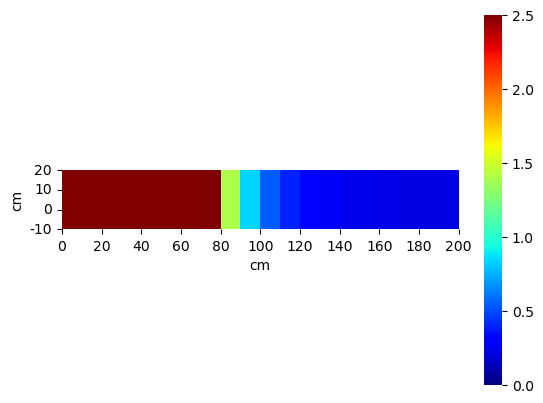

In [30]:
ax = sns.heatmap(B_a_net.cpu().detach().numpy(), vmin=0, square=True, cmap="jet")

y_num_ticks = 4
yticks = np.linspace(0, N_a, y_num_ticks, dtype=np.int32)
yticklabels = [int(range(N_a + 1)[idx]) * 10 - 10 for idx in yticks]

ax.invert_yaxis()
ax.set_ylabel('cm')
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels, rotation='horizontal')

x_num_ticks = 11
xticks = np.linspace(0, M_a, x_num_ticks, dtype=np.int32)
xticklabels = [int(range(M_a + 1)[idx]) * 10 for idx in xticks]

ax.set_xlabel('cm')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation='horizontal')

In [31]:
def G_m(q_m):
    factor = torch.exp((q_m - qc_m) * r_m)
    return (fmin_m + fmax_m * factor) / (1 + factor)
    
def z_m(q_m):
    F_val = G_m(q_m)
    if F_val >= 0:
        return F_val
    else:
        return 0.0

In [32]:
def q_t(area, i=None, j=None):
    if i is not None and j is not None:
        return area[j][i]
    else:
        return area

def F_t(area, i=None, j=None):
    if i is not None and j is not None:
        factor = torch.exp((q_t(area, i, j) - qc_t) * r_t)
        return (fmin_t + fmax_t * factor) / (1 + factor)
    else:
        factor = torch.exp((area - qc_t) * r_t)
        return (fmin_t + fmax_t * factor) / (1 + factor)
    
def z_t(area, i=None, j=None):
    if i is not None and j is not None:
        t1 = F_t(area, i, j)
        if t1 > 0:
            return t1
        else:
            return 0
    else:
        t1 = F_t(area)
        t2 = torch.zeros(area.shape[0], area.shape[1], device=device)
        return torch.where(t1 >= 0, t1, t2).to(device)

In [33]:
def q_a(area, i=None, j=None):
    if i is not None and j is not None:
        return area[j][i]
    else:
        return area

def F_a(area, i=None, j=None):
    if i is not None and j is not None:
        factor = torch.exp((q_a(area, i, j) - qc_a) * r_a)
        return (fmin_a + fmax_a * factor) / (1 + factor)
    else:
        factor = torch.exp((area - qc_a) * r_a)
        return (fmin_a + fmax_a * factor) / (1 + factor)
    
def z_a(area, i=None, j=None):
    if i is not None and j is not None:
        t1 = F_a(area, i, j)
        if t1 > 0:
            return t1
        else:
            return torch.tensor(0)
    else:
        t1 = F_a(area)
        t2 = torch.zeros(area.shape[0], area.shape[1], device=device)
        return torch.where(t1 >= 0, t1, t2).to(device)

In [34]:
def u_m(area_t, area_a):
    return torch.mul(W_t_net, z_t(area_t)).sum() + torch.mul(W_a_net, z_a(area_a)).sum()

In [35]:
def I2_t(area):
    tmp_area = torch.zeros(N_t, M_t, device=device)
    
#     print('z_t', z_t(area).sum())
    
    for i in range(M_t):
        for j in range(N_t):
            tmp_net = L_net_t[(i + 1, j + 1)] * z_t(area)
            tmp_area[j][i] = tmp_net.sum()
            
    return tmp_area

def phi2_t(d=0.5, delta_x_l=0.2, delta_y_n=0.2):
    area_t = torch.zeros(N_t, M_t, device=device)
    
    for i in range(M_t):
        for j in range(N_t):
            sum_phi_t = 0.0
            
            for x_l in np.arange(delta_x_l, 20, delta_x_l):
                for y_n in np.arange(delta_y_n, 10, delta_y_n):
                    x_i = x_t(i + 1)
                    y_j = y_t(j + 1)
                    
#                     sum_phi_t += I_t(x_l, y_n) * phi_t(x_l, y_n, x_i, y_j) * delta_x_l * delta_y_n
                    sum_phi_t += I_t(x_l, y_n) * phi_t(x_l, y_n, x_i, y_j)
            
            area_t[j][i] = sum_phi_t
                    
    return area_t

def B2_t(q_m):
    return B_t_net + z_m(q_m)

In [36]:
s = time.time()

phi_t_net = phi2_t(delta_x_l=delta_val, delta_y_n=delta_val)

time.time() - s

22.941609859466553

<AxesSubplot: >

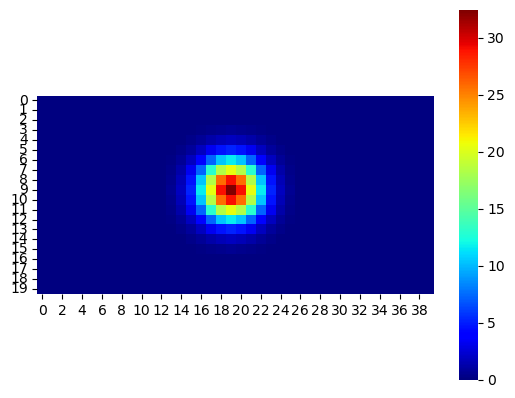

In [37]:
sns.heatmap(phi_t_net.cpu().detach().numpy(), square=True, cmap="jet")

In [38]:
def I2_a(area):
    tmp_area = torch.zeros(N_a, M_a, device=device)
    
#     print('z_a', z_a(area).sum())
    
    for i in range(M_a):
        for j in range(N_a):
            tmp_net = L_net_a[(i + 1, j + 1)] * z_a(area)
            tmp_area[j][i] = tmp_net.sum()
            
    return tmp_area
    
#     sum_val = 0.0
    
#     for h in range(M_a):
#         for k in range(N_a):
# #             tmp_net = L_net_a[(h + 1, k + 1)] * z_a(area)
#             tmp_net = L_net_a[(h + 1, k + 1)] * z_a(area)[k][h]
#             sum_val += tmp_net.sum()
            
#     return sum_val

def phi2_a(d=10, delta_x_l=0.2, delta_y_n=0.2):
    area_a = torch.zeros(N_a, M_a, device=device)
    
    for i in range(M_a):
        for j in range(N_a):
            sum_phi_a = 0.0
            
            for x_l in np.arange(delta_x_l, 200, delta_x_l):
                for y_n in np.arange(delta_y_n, 30, delta_y_n):
                    x_i = x_a(i + 1)
                    y_j = y_a(j + 1)
                    
#                     sum_phi_a += I_a(x_l, y_n) * phi_a(x_l, y_n, x_i, y_j) * delta_x_l * delta_y_n
                    sum_phi_a += I_a(x_l, y_n) * phi_a(x_l, y_n, x_i, y_j)
            
            area_a[j][i] = sum_phi_a
            
    return area_a

def B2_a(q_m):
    return B_a_net + z_m(q_m)

In [39]:
s = time.time()

phi_a_net = phi2_a(delta_x_l=delta_val, delta_y_n=delta_val)

time.time() - s

54.12363123893738

<AxesSubplot: >

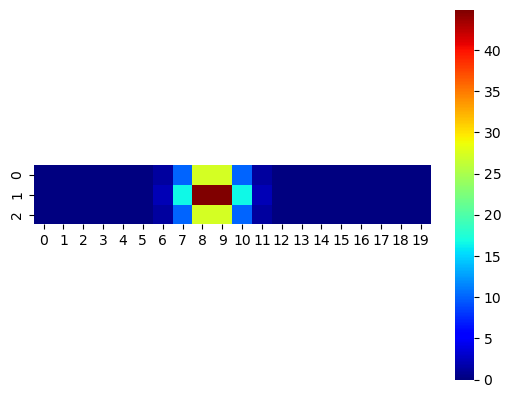

In [40]:
sns.heatmap(phi_a_net.cpu().detach().numpy(), square=True, cmap="jet")

In [41]:
adjust_param = 1

In [42]:
def u_t(area, q_m):
#     return I2_t(area) + B2_t(q_m)
    return phi_t_net * adjust_param + I2_t(area) + B2_t(q_m)

def fire_t(area, q_m, d_t=0.4):
    # * torch.exp(torch.tensor(1))
    d_q = -q_t(area) + u_t(area, q_m)
    area = area + 1/tau * d_t * d_q
    return area

In [43]:
def u_a(area, q_m):
#     return I2_a(area) + B2_a(q_m)
    return phi_a_net * adjust_param + I2_a(area) + B2_a(q_m)

def fire_a(area, q_m, d_t=0.4):
    # * torch.exp(torch.tensor(1))
    d_q = -q_a(area) + u_a(area, q_m)
    area = area + 1/tau * d_t * d_q
    return area

In [44]:
area_t = torch.zeros(N_t, M_t, device=device)
area_a = torch.zeros(N_a, M_a, device=device)

q_m = torch.tensor(0.0)

for i in tqdm(range(int(total_time/d_t))):
    area_t = fire_t(area_t, q_m, d_t)
    area_a = fire_a(area_a, q_m, d_t)
    
    d_qm = -q_m + u_m(area_t, area_a)
    
    q_m = q_m + 1/tau * d_t * d_qm

print(q_m)

  0%|          | 0/500 [00:00<?, ?it/s]

tensor(149.7832, device='cuda:0')


In [45]:
[19, 34, 55, 76, 91]
[161.2876, 164.9522, 165.4480, 159.9066, 148.2969]

def to_1(val):
    return (val - 148.2969) / (165.4480 - 148.2969)

Text(0, 0.5, 'multisensory neuron activation')

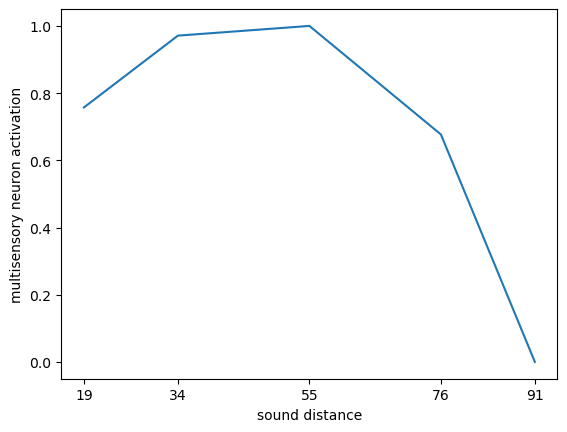

In [46]:
plt.figure()
plt.plot([19, 34, 55, 76, 91], [to_1(i) for i in [161.2876, 164.9522, 165.4480, 159.9066, 148.2969]])

plt.xticks([19, 34, 55, 76, 91], [19, 34, 55, 76, 91])
plt.xlabel('sound distance')
plt.ylabel('multisensory neuron activation')

[Text(0, 0, '0'), Text(20, 0, '20'), Text(40, 0, '40')]

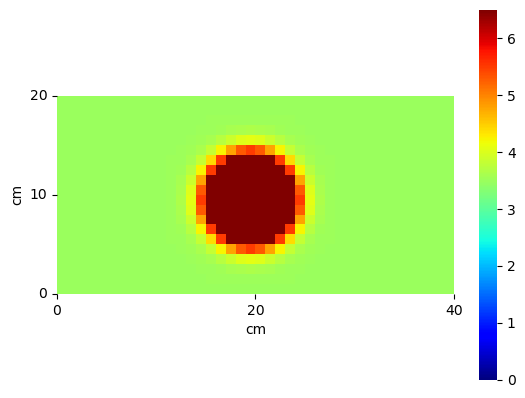

In [47]:
ax = sns.heatmap(area_t.cpu().detach().numpy(), vmin=0, vmax=6.5, square=True, cmap="jet")

y_num_ticks = 3
yticks = np.linspace(0, N_t, y_num_ticks, dtype=np.int32)
yticklabels = [int(range(N_t + 1)[idx]) for idx in yticks]

ax.invert_yaxis()
ax.set_ylabel('cm')
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)

x_num_ticks = 3
xticks = np.linspace(0, M_t, x_num_ticks, dtype=np.int32)
xticklabels = [int(range(M_t + 1)[idx]) for idx in xticks]

ax.set_xlabel('cm')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation='horizontal')

[Text(0, 0, '0'),
 Text(2, 0, '20'),
 Text(4, 0, '40'),
 Text(6, 0, '60'),
 Text(8, 0, '80'),
 Text(10, 0, '100'),
 Text(12, 0, '120'),
 Text(14, 0, '140'),
 Text(16, 0, '160'),
 Text(18, 0, '180'),
 Text(20, 0, '200')]

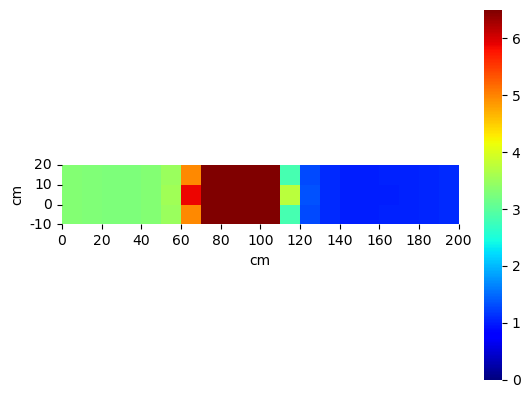

In [48]:
ax = sns.heatmap(area_a.cpu().detach().numpy(), vmin=0, vmax=6.5, square=True, cmap="jet")

y_num_ticks = 4
yticks = np.linspace(0, N_a, y_num_ticks, dtype=np.int32)
yticklabels = [int(range(N_a + 1)[idx]) * 10 - 10 for idx in yticks]

ax.invert_yaxis()
ax.set_ylabel('cm')
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels, rotation='horizontal')

x_num_ticks = 11
xticks = np.linspace(0, M_a, x_num_ticks, dtype=np.int32)
xticklabels = [int(range(M_a + 1)[idx]) * 10 for idx in xticks]

ax.set_xlabel('cm')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation='horizontal')

In [49]:
area_t_90 = area_t * 0.9

area_a_90 = area_a * 0.9

In [50]:
area_t = torch.zeros(N_t, M_t, device=device)
area_a = torch.zeros(N_a, M_a, device=device)

q_m = torch.tensor(0.0)

RT = 0

for i in tqdm(range(int(total_time/d_t))):
    area_t = fire_t(area_t, q_m, d_t)
    area_a = fire_a(area_a, q_m, d_t)
    
    if torch.gt(area_t, area_t_90).all():
        RT = ((i + 1) * d_t) * 3 + 60
        print(i)
        print(RT)
        break
    
    d_qm = -q_m + u_m(area_t, area_a)
    
    q_m = q_m + 1/tau * d_t * d_qm

  0%|          | 0/500 [00:00<?, ?it/s]

138
226.8


Text(0.5, 0, 'sound distance')

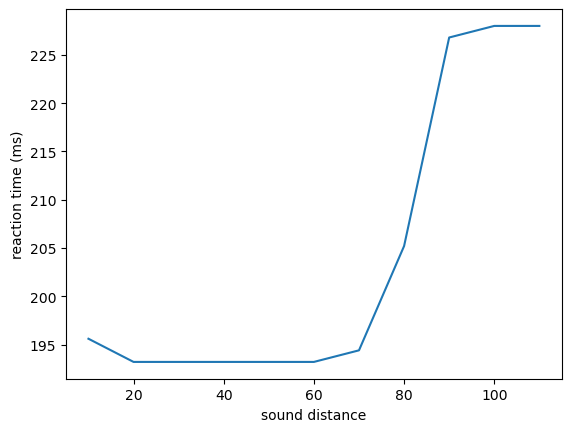

In [55]:
RT = 196.8

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
[195.6, 193.2, 193.2, 193.2, 193.2, 193.2, 194.4, 205.2, 226.8, 228.0, 228.0]

plt.figure()
plt.plot([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], [195.6, 193.2, 193.2, 193.2, 193.2, 193.2, 194.4, 205.2, 226.8, 228.0, 228.0])

plt.ylabel('reaction time (ms)')
plt.xlabel('sound distance')

In [52]:
all_end = time.time()

In [53]:
all_end - all_start

325.4936451911926